In [2]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v5 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.1 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1

In [3]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math

In [4]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 0.         -0.          0.         -0.          0.02       -0.
  0.11059734  0.         -0.         -0.00191829]


In [5]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
    #self.fc4=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions

In [21]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    #self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=128, fc2_dims=128)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
    #batch = np.random.permutation(max_mem)[:self.batch_size]
    #mem = np.array(exp_buffer)[perm_batch]

    #batch=np.random.choice(max_mem,self.batch_size,replace=False)
    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min

In [6]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()

  def step_graph(self,step_list,num_of_eps):
      self.step_list=step_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.step_list)
      plt.xlabel('Episodes')
      plt.ylabel('Steps_to_score')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

goal episode 0 step= 116
---Avg reward last: 19.819910733855615 Avg score last 1.0 Avg steps 117.0 episode= 0 ---
goal episode 2 step= 115
goal episode 3 step= 117
goal episode 5 step= 118
goal episode 6 step= 115
---Avg reward last: 4.12581674654753 Avg score last 0.4 Avg steps 120.4 episode= 10 ---
goal episode 11 step= 122
goal episode 13 step= 126
goal episode 14 step= 111
goal episode 15 step= 131
goal episode 16 step= 144
goal episode 18 step= 150
goal episode 20 step= 155
---Avg reward last: -21.642746311159687 Avg score last 0.7 Avg steps 137.9 episode= 20 ---
goal episode 21 step= 146
goal episode 23 step= 111
goal episode 26 step= 138
---Avg reward last: -38.594331454415006 Avg score last 0.3 Avg steps 137.5 episode= 30 ---
goal episode 31 step= 140
goal episode 39 step= 157
goal episode 40 step= 152
---Avg reward last: -211.22851060472584 Avg score last 0.3 Avg steps 149.6 episode= 40 ---
goal episode 42 step= 152
goal episode 45 step= 158
goal episode 46 step= 161
goal epis

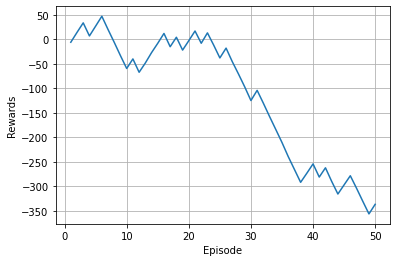

Last 50 episodes avg score 0.42


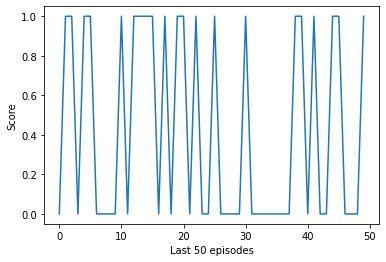

goal episode 51 step= 156
goal episode 52 step= 131
goal episode 53 step= 143
goal episode 55 step= 109
goal episode 57 step= 155
goal episode 58 step= 149
goal episode 59 step= 138
goal episode 60 step= 149
---Avg reward last: -280.41322127533533 Avg score last 0.8 Avg steps 144.2 episode= 60 ---
goal episode 61 step= 145
goal episode 62 step= 110
goal episode 63 step= 149
goal episode 64 step= 153
goal episode 65 step= 146
goal episode 66 step= 153
goal episode 67 step= 162
goal episode 68 step= 153
goal episode 69 step= 118
goal episode 70 step= 143
---Avg reward last: -117.28115467709566 Avg score last 1.0 Avg steps 144.2 episode= 70 ---
goal episode 71 step= 148
goal episode 72 step= 146
goal episode 73 step= 150
goal episode 74 step= 148
goal episode 75 step= 157
goal episode 76 step= 145
goal episode 77 step= 161
goal episode 78 step= 147
goal episode 79 step= 159
goal episode 80 step= 158
---Avg reward last: 75.31774076060417 Avg score last 1.0 Avg steps 152.9 episode= 80 ---
g

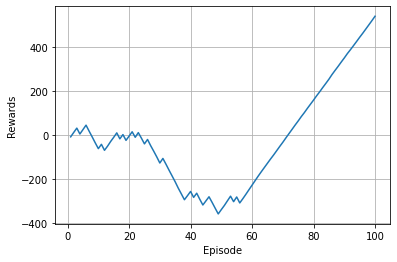

Last 50 episodes avg score 0.96


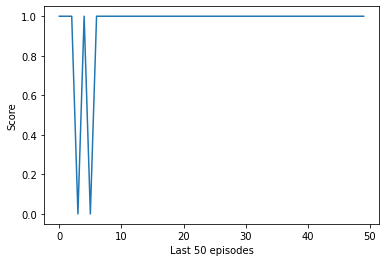

goal episode 101 step= 162
goal episode 102 step= 151
goal episode 103 step= 157
goal episode 104 step= 165
goal episode 105 step= 155
goal episode 107 step= 120
goal episode 108 step= 159
goal episode 109 step= 147
goal episode 110 step= 136
---Avg reward last: 620.329432563483 Avg score last 0.9 Avg steps 149.6 episode= 110 ---
goal episode 111 step= 146
goal episode 112 step= 149
goal episode 113 step= 132
goal episode 114 step= 147
goal episode 115 step= 146
goal episode 116 step= 143
goal episode 117 step= 149
goal episode 118 step= 141
goal episode 119 step= 156
goal episode 120 step= 128
---Avg reward last: 789.6610862043045 Avg score last 1.0 Avg steps 144.7 episode= 120 ---
goal episode 121 step= 137
goal episode 122 step= 109
goal episode 123 step= 160
goal episode 124 step= 151
goal episode 125 step= 123
goal episode 126 step= 152
goal episode 127 step= 147
goal episode 128 step= 128
goal episode 129 step= 151
goal episode 130 step= 151
---Avg reward last: 984.6772168759295 

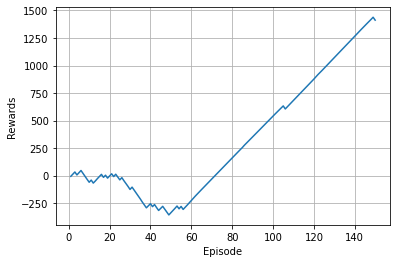

Last 50 episodes avg score 0.96


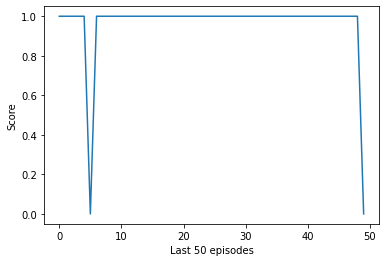

goal episode 151 step= 106
goal episode 152 step= 121
goal episode 153 step= 141
goal episode 154 step= 144
goal episode 155 step= 147
goal episode 156 step= 125
goal episode 157 step= 148
goal episode 158 step= 143
goal episode 159 step= 147
goal episode 160 step= 146
---Avg reward last: 1521.2371704276134 Avg score last 1.0 Avg steps 137.8 episode= 160 ---
goal episode 161 step= 143
goal episode 162 step= 114
goal episode 163 step= 142
goal episode 164 step= 141
goal episode 165 step= 152
goal episode 166 step= 113
goal episode 167 step= 130
goal episode 168 step= 147
goal episode 169 step= 144
goal episode 170 step= 148
---Avg reward last: 1716.7715957573614 Avg score last 1.0 Avg steps 138.4 episode= 170 ---
goal episode 171 step= 146
goal episode 172 step= 129
goal episode 173 step= 120
goal episode 174 step= 142
goal episode 175 step= 123
goal episode 176 step= 144
goal episode 177 step= 146
goal episode 178 step= 109
goal episode 180 step= 119
---Avg reward last: 1901.1223696406

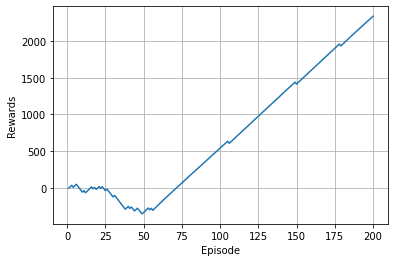

Last 50 episodes avg score 0.98


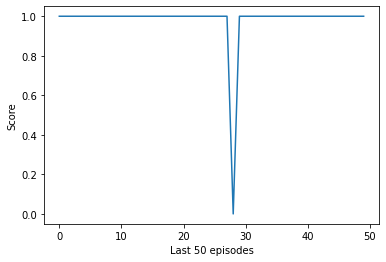

goal episode 201 step= 139
goal episode 202 step= 154
goal episode 203 step= 116
goal episode 204 step= 139
goal episode 205 step= 153
goal episode 206 step= 109
goal episode 207 step= 131
goal episode 208 step= 116
goal episode 209 step= 113
goal episode 210 step= 108
---Avg reward last: 2444.576710655243 Avg score last 1.0 Avg steps 128.8 episode= 210 ---
goal episode 211 step= 119
goal episode 212 step= 145
goal episode 213 step= 118
goal episode 214 step= 113
goal episode 215 step= 127
goal episode 217 step= 124
goal episode 218 step= 135
goal episode 219 step= 134
goal episode 220 step= 116
---Avg reward last: 2615.67026178598 Avg score last 0.9 Avg steps 126.2 episode= 220 ---
goal episode 221 step= 114
goal episode 222 step= 148
goal episode 223 step= 162
goal episode 224 step= 146
goal episode 225 step= 115
goal episode 226 step= 122
goal episode 228 step= 138
goal episode 229 step= 115
goal episode 230 step= 137
---Avg reward last: 2768.573860239435 Avg score last 0.9 Avg step

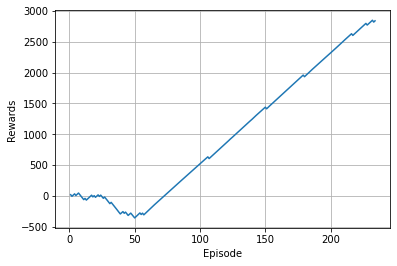

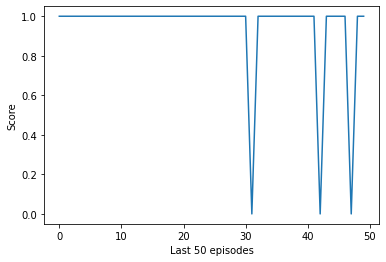

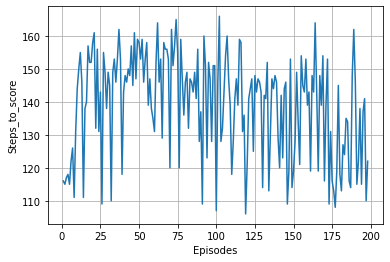

In [26]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.00115 ,input_dims= [10], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0
shout =0


num_of_eps = 801
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")



   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
     

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    
    if(done ==1 and reward != 1): #if ball is out ,loses -2
      #print("Ball is out reward:",reward)
      reward = reward -10 #12
      #print("ball is out -10","episode",i,"Ball Position",observation[4],observation[5],observation[6],"step=",steps)
      terminal =0


    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward += 35 #35


      terminal= terminal +1
      goal_steps.append(steps)

    if((observation[0]<0.5)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    #if((observation[0]>0.6) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      #print("shout entos periohis Ball Position",observation[4],observation[5],observation[6],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.25) #oso pio makria einai toso perissotero xanei
  

    #custom reward here
 
    
   
    score+= reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #Terminate if last 50, 100 and 200 episodes has the same score average
  if( np.mean(score_list[-50:]) > 0.92 and (abs(np.mean(score_list[-50:]) - np.mean(score_list[-100:])) < 0.04) and (abs(np.mean(score_list[-100:]) - np.mean(score_list[-200:]))<0.04) and  i>100):
    print("END OF TRAINING")
    print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
    all_prints.rew_graph(rew_list[-i:],i)
    plt.plot(score_list[-50:])
    plt.xlabel('Last 50 episodes')
    plt.ylabel('Score')
    plt.plot()
    plt.show()
    break

  episode = episode +1 
  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
    print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
    plt.plot(score_list[-50:])
    plt.xlabel('Last 50 episodes')
    plt.ylabel('Score')
    plt.plot()
    plt.show()
     
  




#PRINT STEPS 
a = len(goal_steps)   
all_prints.step_graph(goal_steps[-a:],len(goal_steps))